# Interactive Spark Session on Synapse Spark Pool

### Install the azureml-synapse package on your compute instance.

We will pip install the package *azureml-synapse*, but note if you chose to use jupyter lab, then you would need to additionally need to run the command: *!jupyter lab build --minimize=False*

In [96]:
# can't use just yet.
# sklearn_env = Environment("env-synapse")
# conda_dep = CondaDependencies()
# conda_dep.add_conda_package("matplotlib")
# sklearn_env.python.conda_dependencies = conda_dep

# sklearn_env.register(ws)

In [1]:
!pip install -U "azureml-synapse"

     |████████████████████████████████| 2.8 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 109 kB 82.3 MB/s eta 0:00:01
     |████████████████████████████████| 442 kB 68.2 MB/s eta 0:00:01
     |████████████████████████████████| 154 kB 78.9 MB/s eta 0:00:01
     |████████████████████████████████| 109 kB 83.4 MB/s eta 0:00:01
  Created wheel for sparkmagic: filename=sparkmagic-0.16.0-py3-none-any.whl size=57247 sha256=c70d1085636c921576159282af83309c2daee1e7a5290ac5b04929fefff53bd3
  Stored in directory: /home/azureuser/.cache/pip/wheels/69/94/d4/94d1e290dc0c3965449c6d1832ef9b8a86c81bca7bf4e632c7
  Created wheel for hdijupyterutils: filename=hdijupyterutils-0.16.0-py3-none-any.whl size=7697 sha256=00d18aeb9509f3ee15a9f160042a9de6905fab922402adfb745572f8a5281196
  Stored in directory: /home/azureuser/.cache/pip/wheels/21/77/5f/ed23a25516a7d1f93f04fd9953e1985a61694ed9bc3715ccae
  Created wheel for autovizwidget: filename=autovizwidget-0.19.1-py3-none-any.whl size=14544 sh

### Restart your kernal and refresh the web page after doing the install. 

This is due to the fact that package will install the line magic function `%synsapse` that will leverage.
If you try to run the next command, and fail, you probably skipped this step. 

In [1]:
# show help
%synapse ?

::

  %synapse [-s SUBSCRIPTION_ID] [-r RESOURCE_GROUP] [-w WORKSPACE_NAME]
               [-f CONFIG_FILE] [-c COMPUTE_TARGET]
               [--driver-memory DRIVER_MEMORY] [--driver-cores DRIVER_CORES]
               [--executor-memory EXECUTOR_MEMORY]
               [--executor-cores EXECUTOR_CORES] [-n NUM_EXECUTORS]
               [-t SESSION_TIMEOUT] [--start-timeout START_TIMEOUT]
               [-e ENVIRONMENT] [--environment-version ENVIRONMENT_VERSION]
               [command [command ...]]

Magic to execute spark remotely against a Synapse Spark pool.

Sub commands:
    start: Start a Livy session against target AML Synapse compute.
        You can set spark config in the magic body by json format. e.g.

        .. code-block:: python

            %%synapse start --compute-target synapse_compute
            {
                "spark.yarn.appMasterEnv.xxx": "xxx",
                "spark.executorEnv.xxx": "xxx",
                "spark.yarn.maxAppAttempts": 1
            }

   

## Start your spark Session

use Synapse compute linked to the Compute Instance's workspace with an aml envrionment.
conda dependencies specified in the environment will be installed before the spark session started.

Starting the session will take several minutes as it is installing your environment packages into your Spark Session

In [55]:
synapse_compute_name=os.getenv("SYNAPSE_COMPUTE_NAME", "aml-mmsparkpool")

In [56]:
synapse_compute_name

'aml-mmsparkpool'

In [91]:
#synapse start -c $synapse_compute_name -e env-synapse
%synapse start -c $synapse_compute_name -e AzureML-Minimal

Synapse Spark pool now only supports fixed Python version, you can print "sys.version_info" in your script to check current Python version.
Starting session 'aml_notebook_637529' under environment 'env-synapse', this may take several minutes ........................................................................................................................................... Succeeded!


In [ ]:
# Connecting to Data

Currently 3 types of datastores are supported with Synapse Spark
- Blob Storage - providing credentials
- Adls (Gen 1 & 2) - both credential & credential less.

## Example 1: Data loading by HDFS path

### Read data from blob

```python
# setup access key or sas token

sc._jsc.hadoopConfiguration().set("fs.azure.account.key.<storage account name>.blob.core.windows.net", "<acess key>")
sc._jsc.hadoopConfiguration().set("fs.azure.sas.<container name>.<storage account name>.blob.core.windows.net", "sas token")

df = spark.read.parquet("wasbs://<container name>@<storage account name>.blob.core.windows.net/<path>")
```

### Read data from ADLSGen1

```python
# setup service pricinpal which has access of the data
# If no data Credential is setup, the user identity will be used to do access control

sc._jsc.hadoopConfiguration().set("fs.adl.account.<storage account name>.oauth2.access.token.provider.type","ClientCredential")
sc._jsc.hadoopConfiguration().set("fs.adl.account.<storage account name>.oauth2.client.id", "<client id>")
sc._jsc.hadoopConfiguration().set("fs.adl.account.<storage account name>.oauth2.credential", "<client secret>")
sc._jsc.hadoopConfiguration().set("fs.adl.account.<storage account name>.oauth2.refresh.url", "https://login.microsoftonline.com/<tenant id>/oauth2/token")

df = spark.read.csv("adl://<storage account name>.azuredatalakestore.net/<path>")
```

### Read data from ADLSGen2

```python
Read data from Adlsgen2

# setup service pricinpal which has access of the data
# If no data Credential is setup, the user identity will be used to do access control

sc._jsc.hadoopConfiguration().set("fs.azure.account.auth.type.<storage account name>.dfs.core.windows.net","OAuth")
sc._jsc.hadoopConfiguration().set("fs.azure.account.oauth.provider.type.<storage account name>.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider")
sc._jsc.hadoopConfiguration().set("fs.azure.account.oauth2.client.id.<storage account name>.dfs.core.windows.net", "<client id>")
sc._jsc.hadoopConfiguration().set("fs.azure.account.oauth2.client.secret.<storage account name>.dfs.core.windows.net", "<client secret>")
sc._jsc.hadoopConfiguration().set("fs.azure.account.oauth2.client.endpoint.<storage account name>.dfs.core.windows.net", "https://login.microsoftonline.com/<tenant id>/oauth2/token")

df = spark.read.csv("abfss://<container name>@<storage account>.dfs.core.windows.net/<path>")
```

In [21]:
from azureml.core import Workspace, Dataset
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))
print(ws)

default_ds = ws.get_default_datastore()

default_ds.upload_files(files=['./data/train.csv', './data/test.csv'], # Upload the diabetes csv files in /data
                       target_path='titanic/', # Put it in a folder path in the datastore
                       overwrite=True, # Replace existing files of the same name
                       show_progress=True)

Ready to use Azure ML 1.34.0 to work with mm-aml-dev
Workspace.create(name='mm-aml-dev', subscription_id='5da07161-3770-4a4b-aa43-418cbbb627cf', resource_group='mm-machine-learning-dev-rg')
Uploading an estimated of 2 files
Uploading ./data/train.csv
Uploaded ./data/train.csv, 1 files out of an estimated total of 2
Uploading ./data/test.csv
Uploaded ./data/test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_f6e250fe5c064b1793c0810c961c91f1

## Access data

We can leverage a pandas dataframe with our compute instance, but we are unable to leverage the compute clusters in Spark to handle larger datasets.  Below shows the data loaded into a pandas dataframe - not pandas dataframe on a Spark cluster will only leverage the head node, not the cluster itself.

In [22]:

# Get the default datastore
default_ds = ws.get_default_datastore()

tab_data_set = Dataset.Tabular.from_delimited_files(path=(default_ds, 'titanic/train.csv'))
df = tab_data_set.to_pandas_dataframe()

df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,None,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,None,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [25]:
%%synapse

import azureml.core
from azureml.core import Dataset
import os, shutil

print(azureml.core.VERSION)

from azureml.core import Workspace, Dataset
ws = Workspace.get(name='mm-aml-dev', subscription_id='5da07161-3770-4a4b-aa43-418cbbb627cf', resource_group='mm-machine-learning-dev-rg')

# Get the default datastore
default_ds = ws.get_default_datastore()

tab_data_set = Dataset.Tabular.from_delimited_files(path=(default_ds, 'titanic/train.csv'))
df = tab_data_set.to_spark_dataframe()

print('row count:', df.count(),'column count:', len(df.columns))


1.34.0
row count: 891 column count: 12


In [24]:
%%synapse

#from pyspark.sql.functions import col, desc
import pyspark.sql.functions as F
from IPython.display import display

df = spark.read.option("header", "true").csv("wasbs://demo@dprepdata.blob.core.windows.net/Titanic.csv")
df.filter(F.col('Survived') == 1).groupBy('Age').count().orderBy(F.desc('count')).show(5)


+----+-----+
| Age|count|
+----+-----+
|null|   52|
|  24|   15|
|  27|   11|
|  22|   11|
|  35|   11|
+----+-----+
only showing top 5 rows


# Challenge - Cleanse your data

Determine which columns have NULL values and determine as a team what you would like to do with that data.  Save your resulting data to your teams' ADLS Gen2 Storage Location

Helpful Articles for your team's discussion:
[Towards Datascience](https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280)

Potentially helpful article on [sparkbyexamples](https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/#:~:text=In%20PySpark%20DataFrame%20you%20can%20calculate%20the%20count,all%20or%20multiple%20selected%20columns%20of%20PySpark%20DataFrame)



In [26]:
%%synapse

print('row count:', df.count(),'column count:', len(df.columns))
print('')
df.printSchema()

row count: 891 column count: 12

root
 |-- PassengerId: long (nullable = false)
 |-- Survived: long (nullable = false)
 |-- Pclass: long (nullable = false)
 |-- Name: string (nullable = false)
 |-- Sex: string (nullable = false)
 |-- Age: double (nullable = true)
 |-- SibSp: long (nullable = false)
 |-- Parch: long (nullable = false)
 |-- Ticket: string (nullable = false)
 |-- Fare: double (nullable = false)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)


In [27]:
%%synapse
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+


In [31]:
%%synapse
from pyspark.sql.functions import col,isnan,when,count
df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+


In [32]:
%%synapse
cols = df.columns
for c in cols:
    value = df.agg({c: 'avg'})
    median = value.collect()[0][0]
    print(c, median)
    if median != None:
        df = df.na.fill(value=median,subset=[c])


df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

PassengerId 446.0
Survived 0.3838383838383838
Pclass 2.308641975308642
Name None
Sex None
Age 29.69911764705882
SibSp 0.5230078563411896
Parch 0.38159371492704824
Ticket 260318.54916792738
Fare 32.2042079685746
Cabin None
Embarked None
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+


In [33]:
%%synapse
from pyspark.sql.functions import col,isnan,when,count
df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+


In [34]:
%%synapse
cabins = df.select('Cabin').rdd.flatMap(lambda x: x).distinct().collect()
cabins

[None, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24', 'C90', 'C45', 'E8', 'B101', 'D45', 'C46', 'D30', 'E121', 'D11', 'E77', 'F38', 'B3', 'D6', 'B82 

# Leverage a UDF in your Spark code

In [35]:
%%synapse

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

@udf(returnType=StringType())
def get_deck(s):
     return 'M' if s == None else s[0]
    
df = df.withColumn("Cabin", get_deck("Cabin"))

df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|    M|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|    C|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|    M|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|    C|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|    M|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [36]:
%%synapse
from pyspark.sql.functions import col,isnan,when,count
df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+


In [37]:
%%synapse
df.filter(df.Embarked.isNull()).show()

+-----------+--------+------+--------------------+------+----+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+-----+--------+
|         62|       1|     1| Icard, Miss. Amelie|female|38.0|    0|    0|113572|80.0|    B|    null|
|        830|       1|     1|Stone, Mrs. Georg...|female|62.0|    0|    0|113572|80.0|    B|    null|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+-----+--------+


In [38]:
%%synapse
df = df.dropna(subset=["Embarked"])

df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+


In [39]:
%%synapse

print('row count:', df.count(),'column count:', len(df.columns))

row count: 889 column count: 12


# Not ready for prime time 



In [94]:
%%synapse

import matplotlib
import numpy as np
from matplotlib import pyplot as plt

x = np.random.rand(20)
plt.plot(x, '*-', color='red', markersize=10)

plt.show()

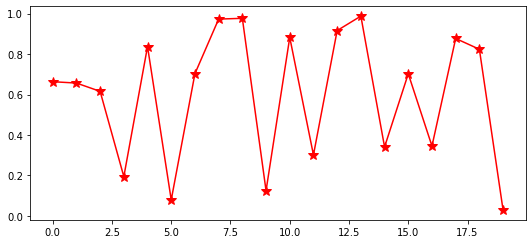

In [95]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

x = np.random.rand(20)
plt.plot(x, '*-', color='red', markersize=10)

plt.show()

In [53]:
%synapse stop

Session stopped.
